# Cropp and face recognition

In [66]:
import numpy as np
import cv2
import os
import glob
import PIL
import PIL.Image as pil_image
import matplotlib.pyplot as plt


def rotate_image(image, angle):
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2,h/2), angle , 1)
    dst = cv2.warpAffine(image, M, (w, h))
    return dst


def is_really_face_detection(face_img):
    if sum(face_img[0,:48] + face_img[:48,0]) == 0:
        return 0
    else: 
        return 1


def get_cropped_face(image):
    # Load the cascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
    # rotate the input image
    image = rotate_image(image, -90)
    # Convert into grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(image)
    aire_face = []
    try:
        for (x, y, w, h) in faces:
            aire_face.append((w)*(h))
        face_index = np.argmax(np.array(aire_face))
        x,y,w,h = faces[face_index]
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), thickness=4)
        only_face = image[y:y+h, x:x+w]
        face_image = cv2.resize(only_face, (48, 48), interpolation=cv2.INTER_CUBIC)
        face_image = face_image.astype('float32')
        face_image = cv2.normalize(face_image, None)
        r = is_really_face_detection(face_image)
        return face_image, 1, r
    except ValueError:
        img_resized = cv2.resize(image, (48, 48), interpolation=cv2.INTER_CUBIC)
        img_resized = img_resized.astype('float32')
        img_resized = cv2.normalize(img_resized, None)
        r = is_really_face_detection(img_resized)
        return img_resized, 0, r

# Store in a dataframe 'dataset'

In [67]:
import pandas as pd
path = '/home/elbaz/Bureau/ITC_DOC/Courses/Project/Fake_Emotions/pic/'
emotions = ['angry', 'disgust', 'surprise', 'happy', 'saddness']
dataset = pd.DataFrame(columns=['flatten_image', 'emotions', 'face_detected', 'is_really_detected'])
i = 0
for e in emotions:
    img_dir = path + e
    data = np.array([np.array(pil_image.open(f)) for f in glob.glob(img_dir+"/*.JPG")])
    for img in data:
        face_img, face_detected, really = get_cropped_face(img)
        dataset.loc[i, 'flatten_image'] = face_img.flatten()
        dataset.loc[i, 'face_detected'] = face_detected
        dataset.loc[i, 'emotions'] = e
        dataset.loc[i, 'is_really_detected'] = really
        i += 1

## Arange dataframe

In [73]:
dataset = dataset[dataset.face_detected==1]
dataset = dataset[dataset.is_really_detected==1]
dataset.drop(['face_detected', 'is_really_detected'], axis=1, inplace=True)
dataset.emotions.replace({'angry': 0, 'disgust': 1, 'surprise': 2, 'happy': 3, 'saddness': 4}, inplace=True)
dataset = dataset.sample(frac=1)

Convert arrat into string.

In [75]:
def array2string(arr):
    l_arr = arr.tolist()
    str_arr = (' ').join(map(str, l_arr))
    return str_arr

dataset.flatten_image = dataset.apply(lambda row: array2string(row.flatten_image), axis=1)

# Save in csv file

In [76]:
dataset.to_csv('image_data.csv')

# Test the dataset

In [77]:
dict_label = {'angry': 0, 'disgust': 1, 'surprise': 2, 'happy': 3, 'sad': 4}

def build_images(img_emotion, sep):
    width, height = 48, 48
    xx = [float(xp) for xp in img_emotion.split(sep)]
    xx = np.asarray(xx).reshape(width, height)
    return xx

def plot_emotion_images(dataset, dict_label, emotion):
    label_emotion = dict_label[emotion]
    emotion_data = dataset[dataset.emotions == label_emotion]
    img_emotion = emotion_data.sample(n=1).flatten_image.values[0]
    img_emotion = build_images(img_emotion, sep=' ')
    plt.imshow(img_emotion, cmap='gray')
    plt.title(emotion)

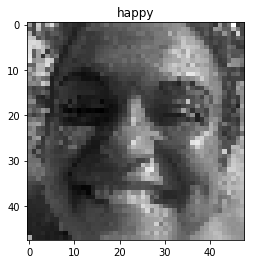

In [82]:
plot_emotion_images(dataset, dict_label, 'happy')